<a href="https://colab.research.google.com/github/Connor1208/git-basics-activity/blob/main/MTH3230_Assignment3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.nn as nn
import yfinance as yf
import pandas as pd
from torch import Tensor
from typing import List
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Daily open/high/low/close/volume for Apple (AAPL), 1980–present.
# Forecasting task: Predict next-day closing price or return.
aapl = yf.Ticker("AAPL")
hist = aapl.history(period="max")
# hist = aapl.history(period="1mo")
display(hist.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-10-15 00:00:00-04:00,249.490005,251.820007,247.470001,249.339996,33893600,0.0,0.0
2025-10-16 00:00:00-04:00,248.250000,249.039993,245.130005,247.449997,39777000,0.0,0.0
2025-10-17 00:00:00-04:00,248.020004,253.380005,247.270004,252.289993,49147000,0.0,0.0
2025-10-20 00:00:00-04:00,255.889999,264.380005,255.630005,262.239990,90483000,0.0,0.0
2025-10-21 00:00:00-04:00,261.880005,265.290009,261.829987,262.769989,46659000,0.0,0.0


In [ ]:
# The input data that we want to use to predict tmr's closing value
# TODO: This should be edited to be a window of past features
X = pd.DataFrame(index=hist.index)
X["Close"] = hist["Close"]
X["Volume"] = hist["Volume"]
X["rolling_mean_7"] = hist["Close"].rolling(7).mean()
X["rolling_mean_30"] = hist["Close"].rolling(30).mean()
X["rolling_std_7"] = hist["Close"].rolling(7).std()
X["rolling_std_30"] = hist["Close"].rolling(30).std()
X["pct_change"] = hist["Close"].pct_change()
X = X.dropna()

# The output that we wish to predict is tmr's closing value from historical data
y = X["Close"].shift(-1) # returns copy

# Drop the last row as we can't predict tmr's closing value
y = y.drop(y.index[-1])
X = X.drop(X.index[-1])

# Convert to arrays
y = y.values
X = X.values

print("Size of y: ", y.shape)
print("Size of X: ", X.shape)


Size of y:  (11276,)
Size of X:  (11276, 7)


In [ ]:
# Ref: https://medium.com/@mn05052002/building-a-simple-mlp-from-scratch-using-pytorch-7d50ca66512b
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for training performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Epoch 1/30, Train Loss: 0.114684
Epoch 2/30, Train Loss: 0.002111
Epoch 3/30, Train Loss: 0.001913
Epoch 4/30, Train Loss: 0.001720
Epoch 5/30, Train Loss: 0.001731
Epoch 6/30, Train Loss: 0.001650
Epoch 7/30, Train Loss: 0.001410
Epoch 8/30, Train Loss: 0.001473
Epoch 9/30, Train Loss: 0.001277
Epoch 10/30, Train Loss: 0.001263
Epoch 11/30, Train Loss: 0.001426
Epoch 12/30, Train Loss: 0.001259
Epoch 13/30, Train Loss: 0.001167
Epoch 14/30, Train Loss: 0.001260
Epoch 15/30, Train Loss: 0.001341
Epoch 16/30, Train Loss: 0.001261
Epoch 17/30, Train Loss: 0.001070
Epoch 18/30, Train Loss: 0.001116
Epoch 19/30, Train Loss: 0.001362
Epoch 20/30, Train Loss: 0.001001
Epoch 21/30, Train Loss: 0.001133
Epoch 22/30, Train Loss: 0.001065
Epoch 23/30, Train Loss: 0.001118
Epoch 24/30, Train Loss: 0.000960
Epoch 25/30, Train Loss: 0.001079
Epoch 26/30, Train Loss: 0.001231
Epoch 27/30, Train Loss: 0.001219
Epoch 28/30, Train Loss: 0.000916
Epoch 29/30, Train Loss: 0.001135
Epoch 30/30, Train Loss

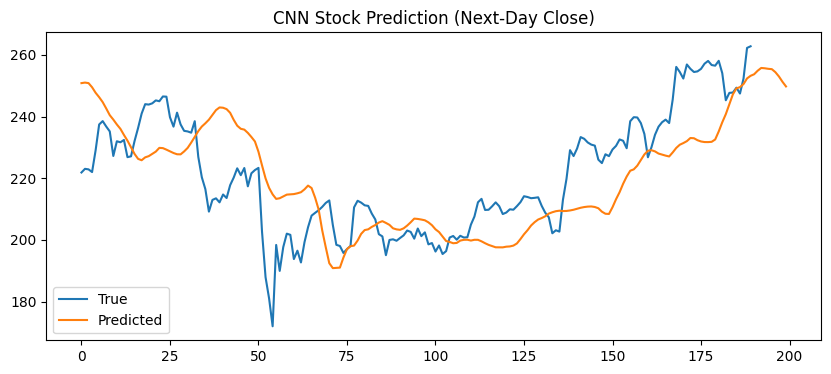

In [ ]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# --- Prepare windowed data ---
def create_sequences(X, y, window=10):
    """Convert to overlapping sequences of length `window`."""
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window = 10
X_seq, y_seq = create_sequences(X, y, window)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

# --- Normalise ---
scaler_X = StandardScaler()
n_samples, seq_len, n_features = X_train.shape
X_train = scaler_X.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
X_test = scaler_X.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], seq_len, n_features)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

# --- Convert to tensors ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# --- Define 1D CNN model ---
class CNN1D(nn.Module):
    def __init__(self, in_features):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_features, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)   # -> (batch, features, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # -> (batch, 64)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out

model = CNN1D(in_features=X_train.shape[2])

# --- Training setup ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

# --- Training loop ---
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.6f}")

# --- Evaluation ---
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy()
    preds = scaler_y.inverse_transform(preds)
    y_true = scaler_y.inverse_transform(y_test)

mse = np.mean((preds - y_true)**2)
print(f"Test MSE: {mse:.4f}")

# --- Plot predictions ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_true[-200:-10], label='True')
plt.plot(preds[-200+10:], label='Predicted')
plt.legend()
plt.title("CNN Stock Prediction (Next-Day Close)")
plt.show()


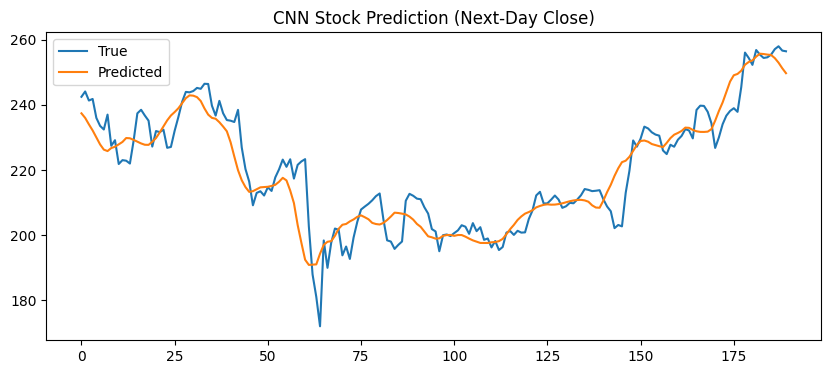

In [ ]:
# --- Plot predictions ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_true[-200:-10], label='True')
plt.plot(preds[-200+10:], label='Predicted')
plt.legend()
plt.title("CNN Stock Prediction (Next-Day Close)")
plt.show()

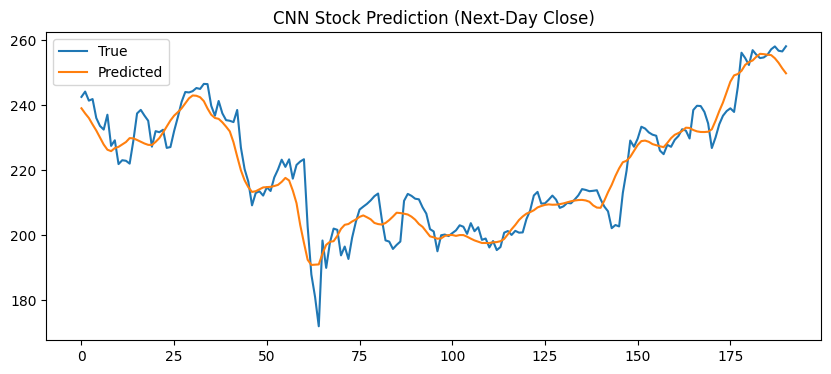

In [ ]:
# --- Plot predictions ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_true[-200:-9], label='True')
plt.plot(preds[-200+9:], label='Predicted')
plt.legend()
plt.title("CNN Stock Prediction (Next-Day Close)")
plt.show()

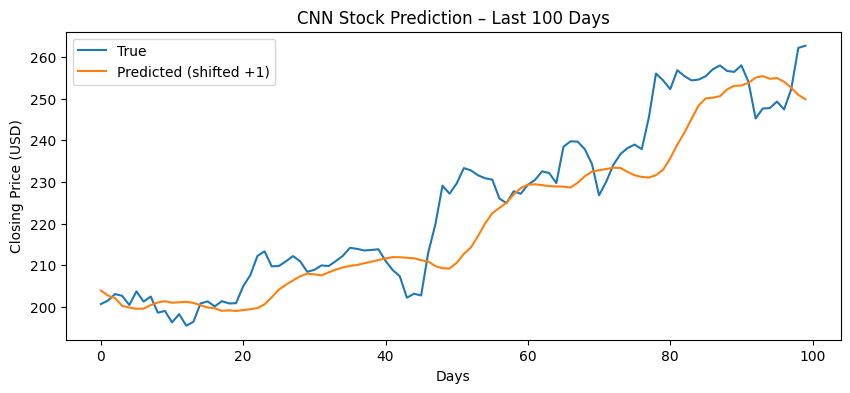

In [ ]:
# --- Plot the most recent 100 test days ---
plt.figure(figsize=(10, 4))
plt.plot(y_true[-100:], label="True")
plt.plot(preds[-100:], label="Predicted (shifted +1)")
plt.legend()
plt.title("CNN Stock Prediction – Last 100 Days")
plt.xlabel("Days")
plt.ylabel("Closing Price (USD)")
plt.show()


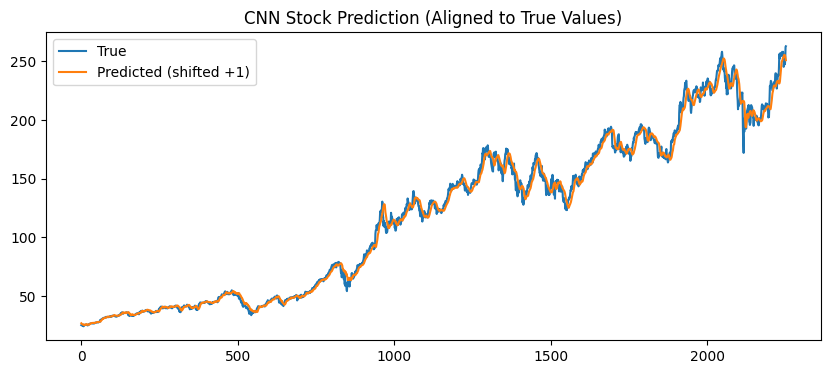

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(y_true[1:], label="True")
plt.plot(preds[:-1], label="Predicted (shifted +1)")
plt.legend()
plt.title("CNN Stock Prediction (Aligned to True Values)")
plt.show()


In [ ]:
# --- Visualise CNN architecture with torchviz ---
!pip install torchviz torchsummary --quiet

from torchviz import make_dot
from torchsummary import summary

# Create a dummy input (same shape as your actual input)
example_input = torch.randn(1, X_train.shape[1], X_train.shape[2])   # (batch=1, seq_len=10, features=7)

# Forward pass
output = model(example_input)

# Visualise computation graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn_graph')   # saves cnn_graph.png in the working directory

# Print detailed layer summary
print("Model summary:\n")
summary(model, input_size=(X_train.shape[1], X_train.shape[2]))


Model summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 32, 8]             704
              ReLU-2                [-1, 32, 8]               0
            Conv1d-3                [-1, 64, 6]           6,208
              ReLU-4                [-1, 64, 6]               0
 AdaptiveAvgPool1d-5                [-1, 64, 1]               0
            Linear-6                   [-1, 32]           2,080
              ReLU-7                   [-1, 32]               0
            Linear-8                    [-1, 1]              33
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


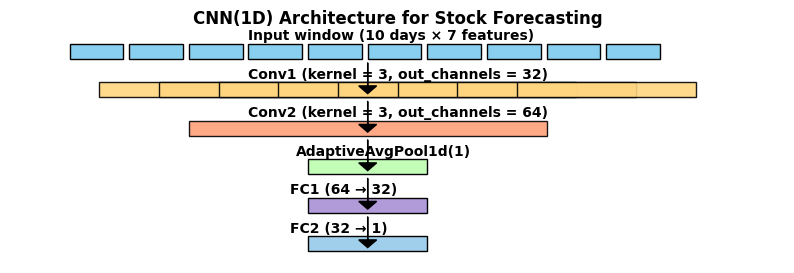

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_cnn_timeline(window=10, kernel_size=3):
    fig, ax = plt.subplots(figsize=(10, 3))

    # --- Input window (10 days) ---
    for i in range(window):
        ax.add_patch(patches.Rectangle((i, 2.3), 0.9, 0.4, color="#89CFF0", ec="k"))
    ax.text(window/2 - 2, 2.8, f"Input window ({window} days × 7 features)", fontsize=10, fontweight="bold")

    # --- Conv1 layer kernels (3-day filters) ---
    for start in range(window - kernel_size + 1):
        ax.add_patch(patches.Rectangle((start + 0.5, 1.3), kernel_size, 0.4, color="#FFD580", ec="k", alpha=0.9))
    ax.text(window/2 - 2, 1.8, f"Conv1 (kernel = {kernel_size}, out_channels = 32)", fontsize=10, fontweight="bold")

    # --- Conv2 layer ---
    ax.add_patch(patches.Rectangle((2, 0.3), 6, 0.4, color="#FFA07A", ec="k", alpha=0.9))
    ax.text(window/2 - 2, 0.8, "Conv2 (kernel = 3, out_channels = 64)", fontsize=10, fontweight="bold")

    # --- Pooling and Dense layers ---
    ax.add_patch(patches.Rectangle((4, -0.7), 2, 0.4, color="#C3FDB8", ec="k"))
    ax.text(3.8, -0.2, "AdaptiveAvgPool1d(1)", fontsize=10, fontweight="bold")

    ax.add_patch(patches.Rectangle((4, -1.7), 2, 0.4, color="#B19CD9", ec="k"))
    ax.text(3.7, -1.2, "FC1 (64 → 32)", fontsize=10, fontweight="bold")

    ax.add_patch(patches.Rectangle((4, -2.7), 2, 0.4, color="#A0CFEC", ec="k"))
    ax.text(3.7, -2.2, "FC2 (32 → 1)", fontsize=10, fontweight="bold")

    # --- Arrows ---
    for y1, y2 in zip([2.3, 1.3, 0.3, -0.7, -1.7], [1.3, 0.3, -0.7, -1.7, -2.7]):
        ax.arrow(window/2, y1 - 0.1, 0, y2 - y1 + 0.4, head_width=0.3, head_length=0.2, fc='k', ec='k')

    ax.set_xlim(-1, window + 2)
    ax.set_ylim(-3, 3)
    ax.axis("off")
    ax.set_title("CNN(1D) Architecture for Stock Forecasting", fontsize=12, fontweight="bold")
    plt.show()

visualize_cnn_timeline(window=10, kernel_size=3)


NameError: name 'y_pred' is not defined

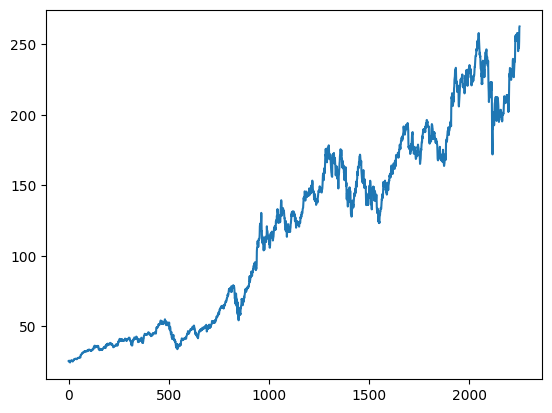

In [ ]:
plt.plot(y_true[1:], label="True")
plt.plot(y_pred[:-1], label="Predicted (shifted +1)")
plt.legend()
